# Unsupervised Clustering on MNIST using KMeans on DINO Features

## Load train features and labels

In [1]:
import os
import torch

processed_data_path = '/kaggle/input/mnist-processed/train_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    train_features = checkpoint['train_features']
    train_labels = checkpoint['train_labels']
    print("Loaded train_features and train_labels from train_data.pt.")

/tmp/ipykernel_30/3520647605.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


Loaded train_features and train_labels from train_data.pt.


## Clustering Accuracy calculation using Hungarian algorithm

In [2]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch

import numpy as np
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Ensure labels are within [0, D-1] range
    y_true = y_true - np.min(y_true)
    y_pred = y_pred - np.min(y_pred)

    # Find number of classes (D)
    D = max(y_pred.max(), y_true.max()) + 1

    # Build the contingency matrix (confusion matrix)
    contingency_matrix = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        contingency_matrix[y_pred[i], y_true[i]] += 1

    # Use Hungarian algorithm (linear sum assignment) to find the best match
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Calculate clustering accuracy
    accuracy = contingency_matrix[row_ind, col_ind].sum() / y_pred.size
    
    # Create a new array to store the final mapped labels
    mapped_labels = np.full_like(y_pred, -1)  # Initialize with -1 (unmapped labels)

    # Assign the mapped labels
    for i in range(len(row_ind)):
        mapped_labels[y_pred == row_ind[i]] = col_ind[i]
    
    return accuracy * 100, mapped_labels  # Return accuracy and the final mapped labels

### Load val set

In [3]:
import os
import torch

processed_data_path = '/kaggle/input/mnist-processed/val_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    val_features = checkpoint['val_features']
    val_labels = checkpoint['val_labels']
    print("Loaded val_features and val_labels from val_data.pt.")

Loaded val_features and val_labels from val_data.pt.


/tmp/ipykernel_30/3177086425.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


### Load test set

In [4]:
import os
import torch

processed_data_path = '/kaggle/input/mnist-processed/test_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    test_features = checkpoint['test_features']
    test_labels = checkpoint['test_labels']
    print("Loaded test_features and test_labels from test_data.pt.")

/tmp/ipykernel_30/2594294806.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


Loaded test_features and test_labels from test_data.pt.


## Initialize KMeans

### Fit on KMeans using elbow method for optimal number of clusters

Clustering Progress: 100%|██████████| 24/24 [13:18<00:00, 33.29s/it]


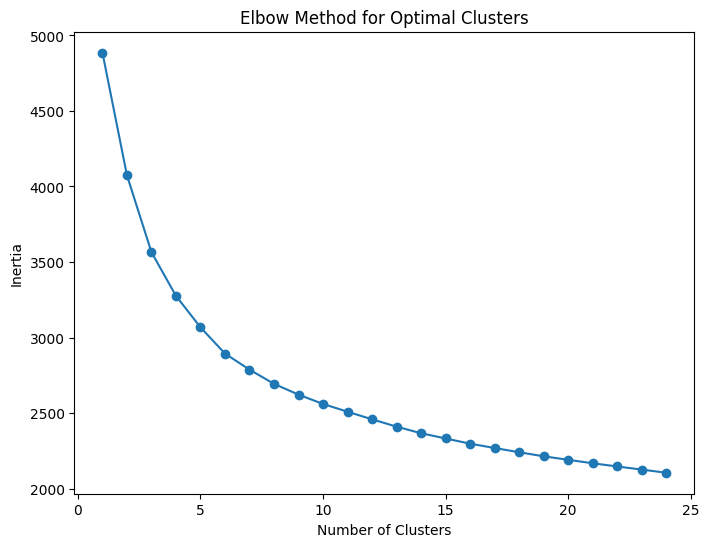

In [5]:
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from sklearn.cluster import KMeans

def elbow_method(features, max_clusters=15):
    inertias = []
    
    # Suppress warnings
    warnings.filterwarnings("ignore")
    
    # Progress bar using tqdm
    for n_clusters in tqdm(range(1, max_clusters + 1), desc="Clustering Progress"):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features)
        inertias.append(kmeans.inertia_)
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal Clusters")
    plt.show()

# Apply the Elbow Method with progress bar and suppressed warnings
elbow_method(train_features, 24)


### Initialize KMeans with the observed optimal number of clusters and fit on train set

In [6]:
from sklearn.cluster import KMeans
# Initialize and fit the KMeans clustering model on the extracted features
n_clusters = 10  # Set the desired number of clusters
clustering_module = KMeans(n_clusters=n_clusters, random_state=42)
clustering_module.fit(train_features)

KMeans(n_clusters=10, random_state=42)

### Accuracy on Train split

In [7]:
predictions = clustering_module.predict(train_features)

acc_score, mapped_labels = clustering_accuracy(train_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 34.552083333333336


### Accuracy on Val split

In [8]:
predictions = clustering_module.predict(val_features)

acc_score, mapped_labels = clustering_accuracy(val_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 34.55833333333334


### Accuracy on Test split

In [9]:
predictions = clustering_module.predict(test_features)

acc_score, mapped_labels = clustering_accuracy(test_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 34.449999999999996


## NMI Score on Test split

In [10]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(test_labels, predictions)
print(f"Normalized Mutual Information (NMI): {100*nmi}")

Normalized Mutual Information (NMI): 32.92601224559231


## ARI Score on Test split

In [11]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(test_labels, predictions)
print(f"Adjusted Rand Index (ARI): {100*ari}")

Adjusted Rand Index (ARI): 18.377598650556052


## t-SNE Plots

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
def plot_tsne(features, predictions, num_classes, title="t-SNE Visualization"):
    if isinstance(features, torch.Tensor):
        features = features.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),
        alpha=0.7, edgecolor='k', s=15
    )
    plt.colorbar(scatter, ticks=range(num_classes))
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()


### t-SNE on Actual test labels

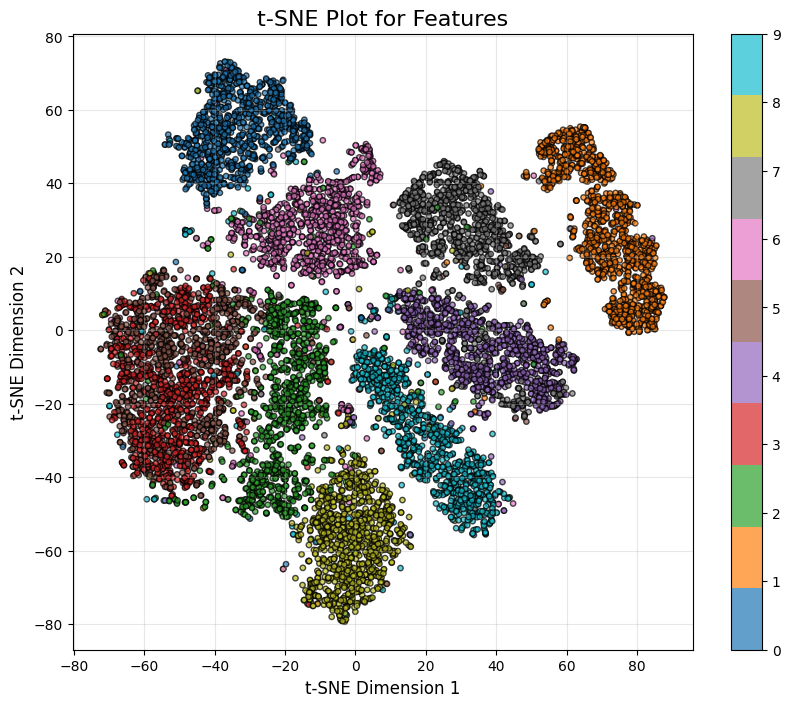

In [13]:
num_classes = len(np.unique(test_labels))  # Get the number of unique classes
plot_tsne(test_features, test_labels, num_classes, title="t-SNE Plot for Features")

### t-SNE on predicted test labels

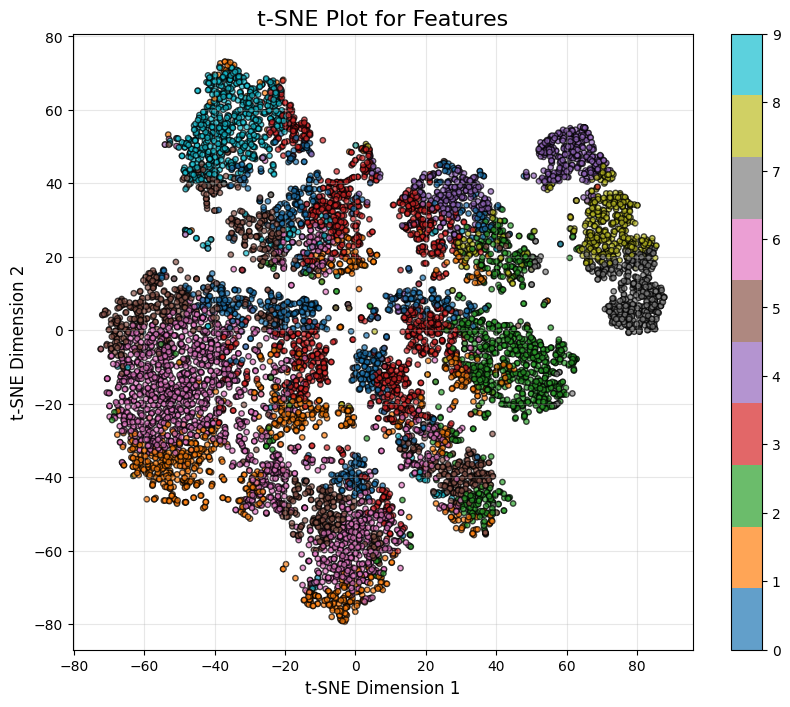

In [14]:
num_classes = len(np.unique(predictions))  # Get the number of unique classes
plot_tsne(test_features, predictions, num_classes, title="t-SNE Plot for Features")